# Sensores Phybox

## Datos adquiridos

Para la realización del ejercicio se recogen datos de 7 clases diferentes:
* Subir escaleras despacio
* Subir escaleras rápido
* Bici con batería
* Bici sin batería
* Andar normal
* Andar trote
* Correr

Conocemos que, poniendo el móvil sobre la mesa:
* El eje x es el que va de izquierda a derecha
* El eje y es el que va de delante a detrás
* El eje z es el que va de arriba a abajo
* Además, el acelerómetro mide la aceleración en m/s^2

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import get_window

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [2]:
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

### 1. Carga de datos

In [3]:
# Solo aceleración en los tres ejes, absoluta no
def carga_df(filename, etiqueta):
    df = pd.read_csv(os.path.join('data', filename)).iloc[:, :4]
    df['etiqueta'] = etiqueta
    df.columns = ['time', 'x', 'y', 'z', 'etiqueta']

    # De cada señal, eliminar los tres primeros y tres últimos segundos
    df = df[df['time'] > 3]
    df = df[df['time'] < df['time'].max() - 3]
    return df

In [4]:
df_andar_normal = carga_df('andar_normal.csv', 'andar_normal')
df_andar_trote = carga_df('andar_trote.csv', 'andar_trote')
df_andar_correr = carga_df('andar_correr.csv', 'andar_correr')

df_subir_despacio1 = carga_df('subir_escaleras_despacio_1.csv', 'subir_escaleras_despacio')
df_subir_despacio2 = carga_df('subir_escaleras_despacio_2.csv', 'subir_escaleras_despacio')
df_subir_despacio3 = carga_df('subir_escaleras_despacio_3.csv', 'subir_escaleras_despacio')
df_subir_rapido1 = carga_df('subir_escaleras_rapido_1.csv', 'subir_escaleras_rapido')
df_subir_rapido2 = carga_df('subir_escaleras_rapido_2.csv', 'subir_escaleras_rapido')
df_subir_rapido3 = carga_df('subir_escaleras_rapido_3.csv', 'subir_escaleras_rapido')
df_subir_rapido4 = carga_df('subir_escaleras_rapido_4.csv', 'subir_escaleras_rapido')
df_subir_rapido5 = carga_df('subir_escaleras_rapido_5.csv', 'subir_escaleras_rapido')
df_subir_rapido6 = carga_df('subir_escaleras_rapido_6.csv', 'subir_escaleras_rapido')

df_bici_con = carga_df('bici_bateria.csv', 'bici_con_bateria')
df_bici_sin = carga_df('bici_sin_bateria.csv', 'bici_sin_bateria')

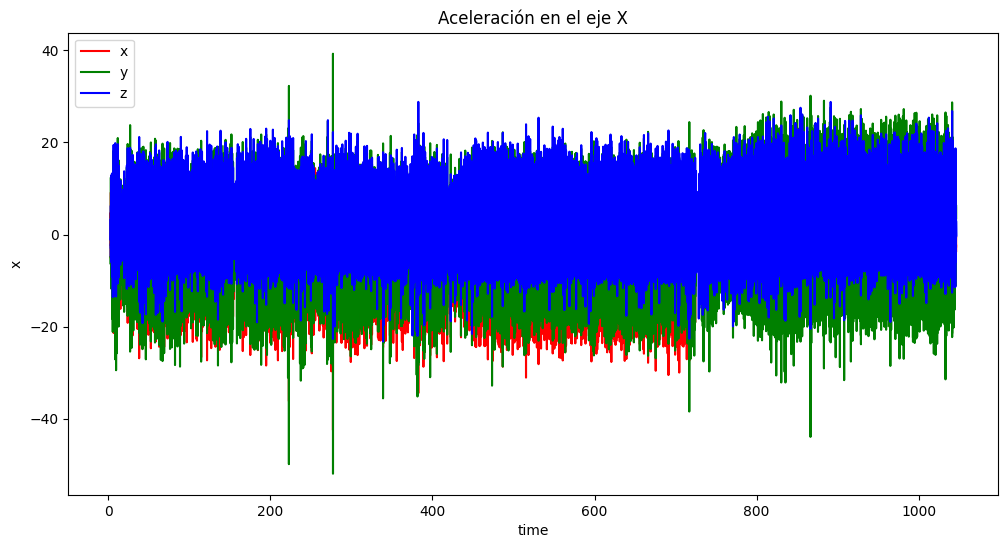

In [5]:
# Visualizar los datos
setup_graph(title='Aceleración en el eje X', x_label='time', y_label='x', fig_size=(12, 6))
plt.plot(df_andar_normal['time'], df_andar_normal['x'], color='r')
plt.plot(df_andar_normal['time'], df_andar_normal['y'], color='g')
plt.plot(df_andar_normal['time'], df_andar_normal['z'], color='b')
plt.legend(['x', 'y', 'z'])
plt.show()

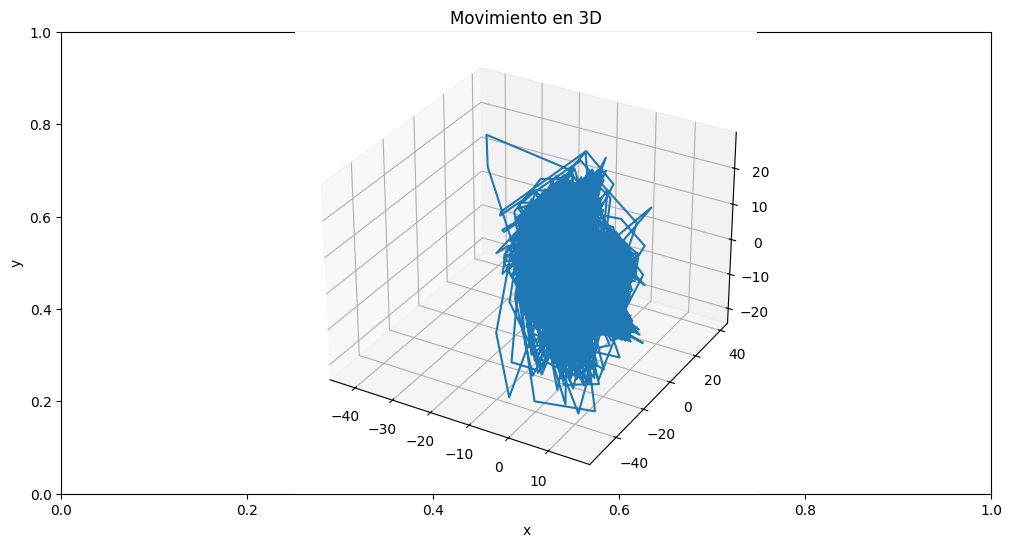

In [6]:
# Recreación del movimiento en 3D
setup_graph(title='Movimiento en 3D', x_label='x', y_label='y', fig_size=(12, 6))
ax = plt.subplot(111, projection='3d')
ax.plot(df_andar_normal['x'], df_andar_normal['y'], df_andar_normal['z'])
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

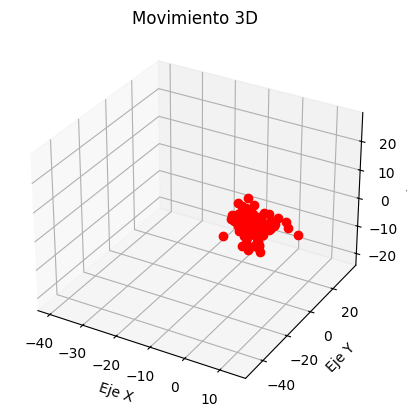

In [7]:
import matplotlib.animation as animation

# Configuración inicial para la figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Configurar los límites del gráfico según tus datos
ax.set_xlim([df_andar_normal['x'].min(), df_andar_normal['x'].max()])
ax.set_ylim([df_andar_normal['y'].min(), df_andar_normal['y'].max()])
ax.set_zlim([df_andar_normal['z'].min(), df_andar_normal['z'].max()])

# Titulo y etiquetas
ax.set_title('Movimiento 3D')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Función de inicialización: plota el fondo de cada cuadro
def init():
    ax.plot(df_andar_normal['x'][0:1], df_andar_normal['y'][0:1], df_andar_normal['z'][0:1], 'ro')
    return fig,

# Función de animación: se llama secuencialmente
def animate(i):
    ax.plot(df_andar_normal['x'][i:i+1], df_andar_normal['y'][i:i+1], df_andar_normal['z'][i:i+1], 'ro')
    return fig,

# Llamar al animador, blit=True significa que solo se redibuja lo que ha cambiado
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(df_andar_normal), interval=20000, blit=True)

# Guardar la animación
ani.save('movimiento_3d.gif', writer='imagemagick', fps=60)

## Metodología

### 2. Obtener características con una ventana móvil que se va solapando: en el dominio del tiempo

#### - Dominio del tiempo

In [8]:
# Dominio del tiempo: max, min, std, kurtosis...
def freq_features(raw_df, window_size=1000, step_size=200): #n_ventanas=200

    # Queremos 200 ventanas: ajustaremos el tamaño de la ventana y del step en función de la longitud de la señal (el número de datos recogidos, las filas del dataframe)

    # (n_puntos-ventana_size)/step_size = n_ventanas
    # Queremos que n_ventanas=200 --> step_size = (n_puntos-ventana_size)/n_ventanas
    # Asumiendo que ventana_size=1000 --> step_size = (n_puntos-1000)/200

    #window_size = 1000
    #step_size = int((len(raw_df)-window_size)/n_ventanas)

    data = []
    for i in range(0, len(raw_df)-window_size, step_size):
        window = raw_df[i:i+window_size]
        features = {}
        for axis in ['x', 'y', 'z']:
            features[f'{axis}_min'] = window[axis].min()
            features[f'{axis}_max'] = window[axis].max()
            features[f'{axis}_median'] = window[axis].median()
            features[f'{axis}_mean'] = window[axis].mean()
            features[f'{axis}_std'] = window[axis].std()
            features[f'{axis}_skewness'] = window[axis].skew()
            features[f'{axis}_kurtosis'] = window[axis].kurtosis()
            features[f'{axis}_iqr'] = window[axis].quantile(0.75) - window[axis].quantile(0.25)
            features[f'{axis}_entropy'] = -np.sum(window[axis] * np.log(window[axis]))
            features[f'{axis}_rms'] = np.sqrt(np.mean(window[axis]**2))          
        features['etiqueta'] = window['etiqueta'].iloc[0]
        data.append(features)
    
    # Generar nombres de columnas basados en las claves del primer elemento de 'data'
    columns = list(data[0].keys())
    return pd.DataFrame(data, columns=columns)

In [9]:
df_andar_normal_features = freq_features(df_andar_normal)
df_andar_trote_features = freq_features(df_andar_trote)
df_andar_correr_features = freq_features(df_andar_correr)

df_subir_despacio1_features = freq_features(df_subir_despacio1)
df_subir_despacio2_features = freq_features(df_subir_despacio2)
df_subir_despacio3_features = freq_features(df_subir_despacio3)

df_subir_rapido1_features = freq_features(df_subir_rapido1)
df_subir_rapido2_features = freq_features(df_subir_rapido2)
df_subir_rapido3_features = freq_features(df_subir_rapido3)
df_subir_rapido4_features = freq_features(df_subir_rapido4)
df_subir_rapido5_features = freq_features(df_subir_rapido5)
df_subir_rapido6_features = freq_features(df_subir_rapido6)

df_bici_con_features = freq_features(df_bici_con)
df_bici_sin_features = freq_features(df_bici_sin)

# Concatenar los dataframes
df_caracts_tiempo_1 = pd.concat([df_andar_normal_features, df_andar_trote_features, df_andar_correr_features, df_subir_despacio1_features, df_subir_despacio2_features, df_subir_despacio3_features, df_subir_rapido1_features, df_subir_rapido2_features, df_subir_rapido3_features, df_subir_rapido4_features, df_subir_rapido5_features, df_subir_rapido6_features, df_bici_con_features, df_bici_sin_features])

c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.

In [10]:
df_caracts_tiempo_1['etiqueta'].value_counts()

etiqueta
andar_normal                514
andar_correr                295
bici_sin_bateria            158
subir_escaleras_rapido      153
bici_con_bateria            118
andar_trote                  89
subir_escaleras_despacio     79
Name: count, dtype: int64

### 3. Clasificador con las features del tiempo: Catboost

In [11]:
# Media por categoría
df_caracts_tiempo_1.groupby('etiqueta').mean()

,x_min,x_max,x_median,x_mean,x_std,x_skewness,x_kurtosis,x_iqr,x_entropy,x_rms,...,z_min,z_max,z_median,z_mean,z_std,z_skewness,z_kurtosis,z_iqr,z_entropy,z_rms
etiqueta,,,,,,,,,,,,,,,,,,,,,
andar_correr,-30.099843,36.793112,-0.842484,0.121782,12.434706,0.168934,-0.101370,17.954235,-13459.526809,12.429492,...,-20.222389,20.118819,0.949348,0.219745,6.207993,-0.180859,0.484696,8.195899,-4621.500410,6.209244
andar_normal,-22.877670,10.754797,0.038277,-0.238280,4.790759,-1.071771,2.862598,5.817212,-2435.602783,4.796767,...,-15.318835,21.228901,0.207032,0.263723,4.080954,0.615643,3.738329,4.490102,-2391.603166,4.087917
andar_trote,-24.494168,28.861874,0.885651,0.175986,10.499826,-0.017556,-0.325933,13.916813,-10317.496958,10.496458,...,-10.764806,9.965606,0.845562,0.512494,3.406824,-0.232281,0.145936,4.644259,-2094.283266,3.444360
bici_con_bateria,-12.465386,9.700034,0.661252,-0.314186,3.875187,-0.703146,0.218750,4.884294,-1499.775315,3.889404,...,-4.046715,4.373746,-0.109767,-0.008881,1.243216,0.288050,0.520805,1.591321,-215.888458,1.286291
bici_sin_bateria,-7.411020,8.219682,-0.046224,-0.190320,2.309310,-0.018802,1.455946,2.975269,-691.629888,2.323540,...,-4.839698,5.523828,-0.166796,0.086539,1.557586,0.374411,1.661545,2.085883,-455.284242,1.575595
subir_escaleras_despacio,-8.749343,10.571592,-0.133320,-0.399468,2.693077,0.102870,0.965393,3.578263,-817.817472,2.724765,...,-16.299623,8.131151,0.048128,-0.100362,2.145638,-1.380377,8.422864,2.142767,-434.187174,2.148347
subir_escaleras_rapido,-15.938342,12.794429,-0.971810,-0.642642,4.045663,0.147633,0.507973,5.310929,-1941.620205,4.096190,...,-24.123039,11.756902,0.084382,-0.032319,3.557926,-1.317321,7.916803,3.028836,-1479.390274,3.558724


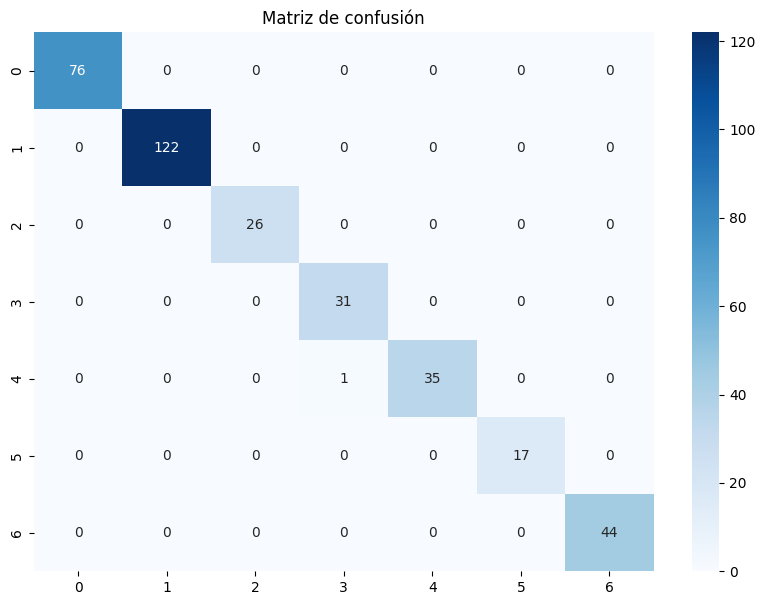

In [12]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=False)
X = df_caracts_tiempo_1.iloc[:, :-1]
y = df_caracts_tiempo_1['etiqueta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)

setup_graph(title='Matriz de confusión', x_label='Predicción', y_label='Real', fig_size=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [13]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')

Accuracy: 99.72%


#### PCA

In [18]:
# PCA de las características temporales
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['pc1', 'pc2'])
df_pca['etiqueta'] = y

setup_graph(title='PCA de las características temporales', x_label='PC1', y_label='PC2', fig_size=(10, 7))
sns.scatterplot(data=df_pca, x='pc1', y='pc2', hue='etiqueta')
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

### 4. Fourier

Para esta sección, desarrollaremos una función que calcule la potencia espectral total y la frecuencia dominante para cada eje. La potencia espectral total se puede calcular como la suma del cuadrado de las magnitudes de la FFT normalizada por la longitud de la ventana, mientras que la frecuencia dominante es simplemente la frecuencia con la máxima magnitud en el espectro.

Al aplicar la FFT a las señales de aceleración, transformamos los datos del dominio del tiempo al dominio de la frecuencia. Esto nos permite identificar las frecuencias dominantes en la señal, que corresponden a los movimientos más repetitivos o destacados durante la actividad medida. La rfft se utiliza en lugar de fft para optimizar el cálculo dado que nuestras señales son reales y no complejas.

* **Frecuencia de Muestreo (fs)**: Este parámetro determina cuán frecuentemente se recogen muestras de la señal. Afecta directamente a la resolución de nuestra FFT y a la frecuencia máxima que podemos analizar correctamente (frecuencia de Nyquist). En nuestro contexto, debe coincidir con la frecuencia de muestreo de los datos del acelerómetro.

In [ ]:
# Para hacer la FFT, primero necesitamos la frecuencia de muestreo
T = df_andar_normal['time'].diff().mean()
Fs = 1/T
print('Fs= ',Fs)

Fs=  99.5108584343765


In [ ]:
# Casi 100 mediciones por segundo

Corrección con ventana de Hann

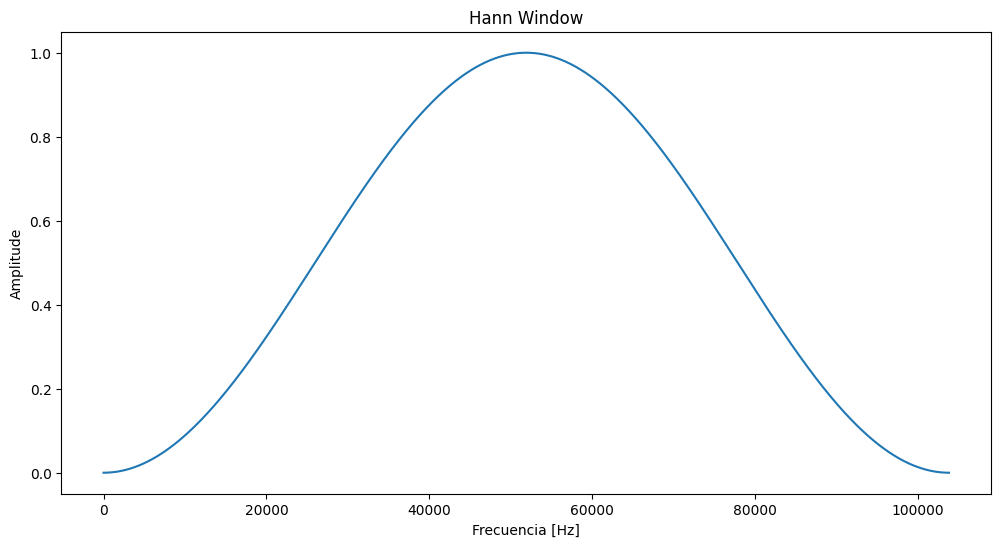

In [ ]:
from scipy.signal import get_window
hann_window = get_window("hann", len(df_andar_normal), fftbins=True)
setup_graph(title='Hann Window', x_label='Frecuencia [Hz]', y_label='Amplitude', fig_size=(12,6))
plt.plot(hann_window)

In [ ]:
# Dominio de la frecuencia (puede que se obtengan mejores resultados) --> MyFFT y de la transformada saco las características
def myFFT(Fs, X):
    window = get_window('hann', len(X), fftbins=True)
    X = X * window
    fft_out = np.fft.rfft(X)
    fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
    num_samples = len(X)
    rfreqs = [(i*1.0/num_samples)*Fs for i in range(num_samples//2+1)]
    return rfreqs, fft_mag

* **Frecuencia Dominante**: Esta es la frecuencia con la mayor amplitud en nuestra FFT. Indica el ritmo principal de la actividad, como el paso mientras se camina o corre. Al extraer esta característica, podemos diferenciar entre diferentes tipos de actividades basadas en su ritmo o frecuencia de movimiento predominante.
* **Potencia Espectral Total**: Representa la suma de las potencias de todas las frecuencias presentes en la señal. Nos da una idea de la "energía" total del movimiento, lo que puede ayudar a distinguir entre movimientos rápidos y energéticos frente a movimientos lentos y suaves. 𝑃𝑆𝐷 = ∑𝑆(𝑓𝑘)

In [ ]:
df_andar_normal

,time,x,y,z,etiqueta
297,3.002448,3.877148,-4.897821,6.071947,andar_normal
298,3.012493,3.900749,-4.615032,5.875602,andar_normal
299,3.022539,4.094637,-4.192273,3.782068,andar_normal
300,3.032584,4.466671,-4.696175,1.666540,andar_normal
301,3.042629,4.741485,-4.879389,0.454007,andar_normal
...,...,...,...,...,...
104089,1046.024311,-3.411024,6.155019,2.894413,andar_normal
104090,1046.034358,-3.106896,5.802662,2.453277,andar_normal
104091,1046.044404,-2.480578,5.316160,1.709926,andar_normal
104092,1046.054451,-1.521915,4.635443,0.951595,andar_normal


In [ ]:
def freq_features(raw_df, window_size=1000, step_size=500):
    data = []
    for i in range(0, len(raw_df)-window_size+1, step_size):
        
        window_data_X = raw_df.iloc[i:i+window_size, 1] # Eje X
        window_data_Y = raw_df.iloc[i:i+window_size, 2] # Eje Y
        window_data_Z = raw_df.iloc[i:i+window_size, 3] # Eje Z

        rfreqs, fft_mag_X = myFFT(Fs, window_data_X)
        _, fft_mag_Y = myFFT(Fs, window_data_Y)
        _, fft_mag_Z = myFFT(Fs, window_data_Z)
        data.append({
            # Frecuencia dominante --> en el número del eje x del histograma donde haya más valores
            'x_dominant_freq': rfreqs[np.argmax(fft_mag_X)], 'y_dominant_freq': rfreqs[np.argmax(fft_mag_Y)], 'z_dominant_freq': rfreqs[np.argmax(fft_mag_Z)],
            # Potencia espectral de cada uno de los ejes
            'x_psd': np.sum(fft_mag_X), 'y_psd': np.sum(fft_mag_Y), 'z_psd': np.sum(fft_mag_Z),
            # Potencia espectral total (Power Spectral Density): sumatorio de magnitudes obtenidas con Fourier en cada ventana de las definidas
            'psd': np.sum(fft_mag_X) + np.sum(fft_mag_Y) + np.sum(fft_mag_Z),
            # Kurtosis espectral: kurtosis de las amplitudes de la señal
            #'kurtosis': pd.Series(fft_mag_X).kurtosis() + pd.Series(fft_mag_Y).kurtosis() + pd.Series(fft_mag_Z).kurtosis(),
            # Skewness espectral: skewness de las amplitudes de la señal
            #'skewness': pd.Series(fft_mag_X).skew() + pd.Series(fft_mag_Y).skew() + pd.Series(fft_mag_Z).skew()
        })

    freq_features = pd.DataFrame(data)
    return freq_features, rfreqs, fft_mag_X

all_features = []
rfreqs_all = []
fft_mag_X_all = []
etiquetas = []
window_size = 1000  # Puede necesitar ajustes
step_size = 200  # Puede necesitar ajustes

for df in [df_andar_normal, df_andar_trote, df_andar_correr, df_subir_despacio1, df_subir_despacio2, df_subir_despacio3, df_subir_rapido1, df_subir_rapido2, df_subir_rapido3, df_subir_rapido4, df_subir_rapido5, df_subir_rapido6, df_bici_con, df_bici_sin]:
    df_features, rfreqs, fft_mag_X = freq_features(df, window_size, step_size)
    all_features.append(df_features)
    rfreqs_all.append(rfreqs)
    fft_mag_X_all.append(fft_mag_X)
    etiquetas.append([df['etiqueta'].iloc[0] for _ in range(len(df_features))])

df_freq_features = pd.concat(all_features, ignore_index=True)
etiquetas = [item for sublist in etiquetas for item in sublist]
df_freq_features['etiqueta'] = etiquetas
df_freq_features

,x_dominant_freq,y_dominant_freq,z_dominant_freq,x_psd,y_psd,z_psd,psd,etiqueta
0,3.880923,1.990217,1.990217,50.787487,61.053253,53.814072,165.654813,andar_normal
1,3.880923,1.890706,1.890706,49.404326,63.020325,50.127153,162.551804,andar_normal
2,1.890706,1.890706,1.890706,45.140475,56.353298,44.079437,145.573210,andar_normal
3,1.890706,1.890706,1.890706,36.691896,41.972187,32.342173,111.006256,andar_normal
4,1.890706,1.890706,2.786304,30.147773,30.480187,25.972091,86.600050,andar_normal
...,...,...,...,...,...,...,...,...
1401,6.965760,8.856466,2.885815,23.151826,22.028932,19.050304,64.231062,bici_sin_bateria
1402,6.965760,8.856466,3.482880,22.949588,18.868426,16.652435,58.470449,bici_sin_bateria
1403,6.965760,7.065271,4.477989,20.803918,16.073335,14.119414,50.996667,bici_sin_bateria
1404,7.065271,5.373586,7.264293,18.296362,13.710232,13.516266,45.522860,bici_sin_bateria


Max: 1.99021716868753


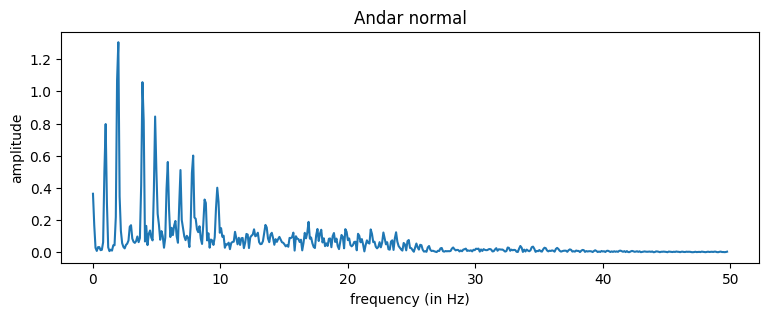

In [ ]:
# Plot
setup_graph(title='Andar normal', x_label='frequency (in Hz)', y_label='amplitude', fig_size=(9,3))
plt.plot(rfreqs_all[0], fft_mag_X_all[0])
print('Max:', rfreqs_all[0][np.argmax(fft_mag_X_all[0])])

Max: 2.6867931777281657


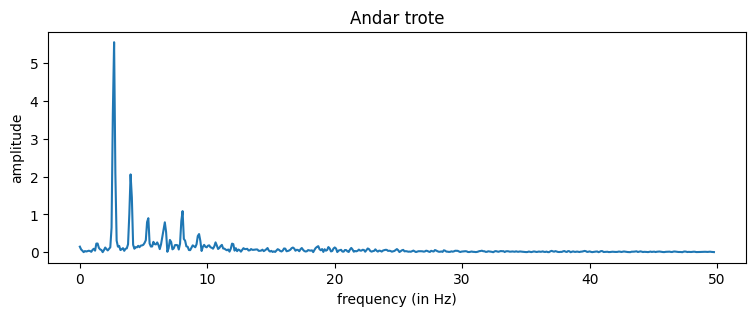

In [ ]:
setup_graph(title='Andar trote', x_label='frequency (in Hz)', y_label='amplitude', fig_size=(9,3))
plt.plot(rfreqs_all[1], fft_mag_X_all[1])
print('Max:', rfreqs_all[1][np.argmax(fft_mag_X_all[1])])

Max: 2.8858148945969186


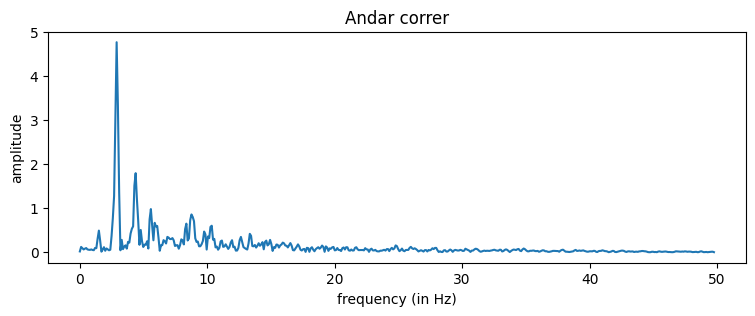

In [ ]:
setup_graph(title='Andar correr', x_label='frequency (in Hz)', y_label='amplitude', fig_size=(9,3))
plt.plot(rfreqs_all[2], fft_mag_X_all[2])
print('Max:', rfreqs_all[2][np.argmax(fft_mag_X_all[2])])

### 5. Clasificador 2 con las nuevas características (mantener mismos modelos para poder comparar resultados)

Implementaremos clasificadores similares a los de la Actividad 3, pero esta vez utilizando las características extraídas del dominio de la frecuencia. Compararemos el rendimiento de los modelos en esta configuración con los resultados anteriores para ver si las características de frecuencia proporcionan una mejor distinción entre las actividades.

Accuracy: 98.86%


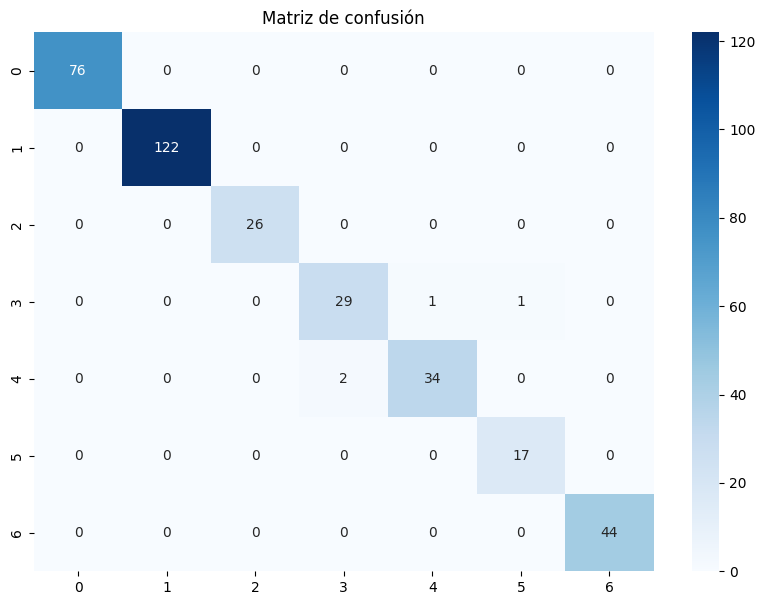


Classification Report:
                           precision    recall  f1-score   support

            andar_correr       1.00      1.00      1.00        76
            andar_normal       1.00      1.00      1.00       122
             andar_trote       1.00      1.00      1.00        26
        bici_con_bateria       0.94      0.94      0.94        31
        bici_sin_bateria       0.97      0.94      0.96        36
subir_escaleras_despacio       0.94      1.00      0.97        17
  subir_escaleras_rapido       1.00      1.00      1.00        44

                accuracy                           0.99       352
               macro avg       0.98      0.98      0.98       352
            weighted avg       0.99      0.99      0.99       352



In [ ]:
# Preparar los datos para el entrenamiento del modelo
X = df_freq_features.drop('etiqueta', axis=1)
y = df_freq_features['etiqueta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Entrenar el modelo. Aquí se usa RandomForest como ejemplo, pero puedes usar cualquier clasificador.
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=False)
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')

setup_graph(title='Matriz de confusión', x_label='Predicción', y_label='Real', fig_size=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

¿Cual, o cuales son las características que más información proveen en el dominio temporal? ¿Y en el frecuencial? demuéstralo representándolo gráficamente

Entrenamiento del Modelo y Extracción de la Importancia de Características

In [ ]:
# Entrenar un modelo para el dominio temporal
X_temporal = df_caracts_tiempo_1.drop('etiqueta', axis=1)
y_temporal = df_caracts_tiempo_1['etiqueta']
model_temporal = RandomForestClassifier(n_estimators=100, random_state=42)
model_temporal.fit(X_temporal, y_temporal)


# Entrenar un modelo para el dominio frecuencial
X_frecuencial = df_freq_features.drop('etiqueta', axis=1)
y_frecuencial = df_freq_features['etiqueta']
model_frecuencial = RandomForestClassifier(n_estimators=100, random_state=42)
model_frecuencial.fit(X_frecuencial, y_frecuencial)

RandomForestClassifier(random_state=42)

Visualización de la Importancia de Características

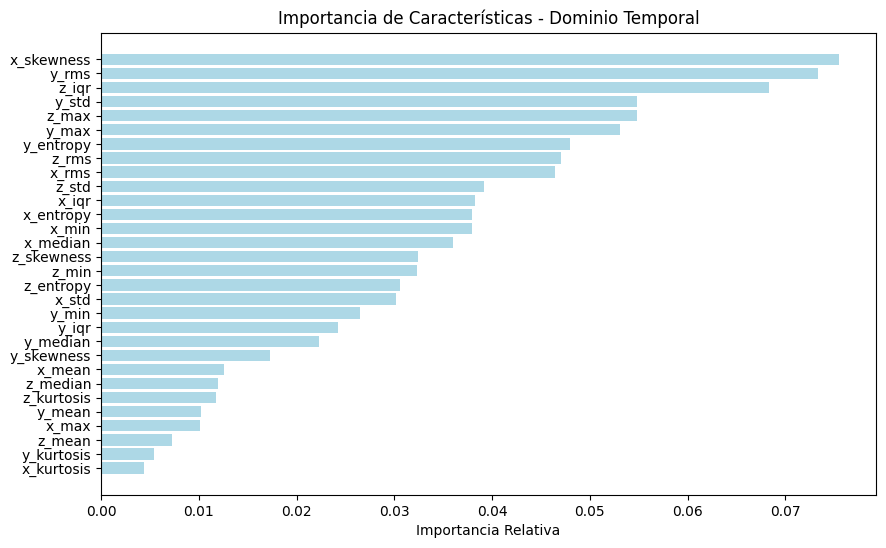

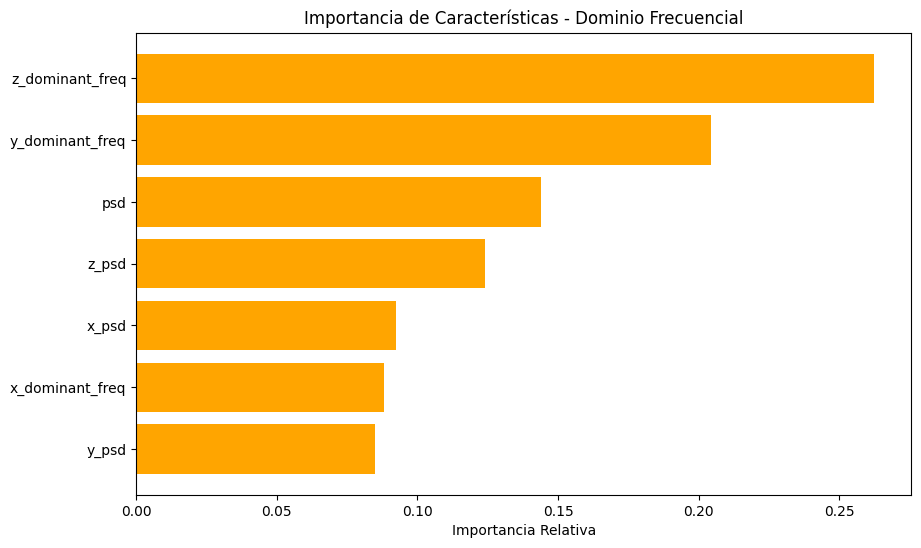

In [ ]:
# Visualización para el dominio temporal
features_temporal = X_temporal.columns
importances_temporal = model_temporal.feature_importances_
indices_temporal = np.argsort(importances_temporal)

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características - Dominio Temporal')
plt.barh(range(len(indices_temporal)), importances_temporal[indices_temporal], color='lightblue', align='center')
plt.yticks(range(len(indices_temporal)), [features_temporal[i] for i in indices_temporal])
plt.xlabel('Importancia Relativa')
plt.show()


# Visualización para el dominio frecuencial
features_frecuencial = X_frecuencial.columns
importances_frecuencial = model_frecuencial.feature_importances_
indices_frecuencial = np.argsort(importances_frecuencial)

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características - Dominio Frecuencial')
plt.barh(range(len(indices_frecuencial)), importances_frecuencial[indices_frecuencial], color='orange', align='center')
plt.yticks(range(len(indices_frecuencial)), [features_frecuencial[i] for i in indices_frecuencial])
plt.xlabel('Importancia Relativa')
plt.show()

Estos gráficos muestran qué características son las más relevantes para los modelos en cada dominio, proporcionando una respuesta visual a cuáles son más informativas. Este enfoque no solo ayuda a entender qué características son más útiles para la clasificación, sino que también puede guiar la ingeniería de características futura y la selección de características para mejorar los modelos de clasificación.

In [ ]:
# Wavelets

# Probar con todas las características de tiempo+freq+wavelets

## Resultados

### 6. La más importante, comparar resultados, explicar modelos creados e interpretar características en ambos dominios

### 7. Conclusiones y líneas futuras

* a
* b
* c

Presentación: 2 mins cada apartado/persona, 5-10 total